In [ ]:
!pip install pytorch-lightning sentence-transformers torchmetrics rich

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os

os.chdir('/content/drive/MyDrive/NLP Group Project/synthetic-squad-main/src')
os.getcwd()

'/content/drive/MyDrive/NLP Group Project/synthetic-squad-main/src'

# Roberta Baseline

## Task 3

### Prepare the Data

In [ ]:
import pandas as pd
from datautils import SynDataModule, SynBatcher


TASK = 3
DPATH = r'/content/drive/MyDrive/NLP Group Project/Texts/punc_data_eval.csv'
MPATH = "roberta-base"

df = pd.read_csv(DPATH)

label2id = {label: idx for idx, label in enumerate(df['alg'].unique())}

In [ ]:
batcher = SynBatcher(tnkzr_path=MPATH,has_targets=False)
eval_dm = SynDataModule(data_path=DPATH, task='aa', label2id=label2id, batcher=batcher)

### Prepare the model

In [ ]:
from modelling import SequenceClassification
from pytorch_lightning.callbacks import(
    EarlyStopping,
    ModelCheckpoint,
    RichModelSummary
)

SAVE_PATH = "'/content/drive/MyDrive/NLP Group Project/models/task3/roberta-base"

# model = SequenceClassification(MPATH, num_labels=len(label2id))
# print("Loaded fresh model")

model = SequenceClassification.load_from_checkpoint("../models/task3/roberta-base/task-3-epoch=2-val_loss=0.20.ckpt")

checkpoint_callback = ModelCheckpoint(
    SAVE_PATH,
    filename=f'task-{TASK}-{{epoch}}-{{val_loss:.2f}}',
    monitor='val_loss',
    save_weights_only=True,
)
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4, patience=8,
    verbose=False,
    mode="min"
)

### Generate model predictions

In [ ]:
from pytorch_lightning import Trainer, seed_everything


seed_everything(42, workers=True)

trainer = Trainer(
    max_epochs=-1,
    deterministic=True,
    accumulate_grad_batches=4,
    callbacks=[checkpoint_callback, early_stop_callback, RichModelSummary()],
    accelerator='gpu',
    log_every_n_steps=16
)

In [ ]:
preds = trainer.predict(model,eval_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [ ]:
print(preds)

In [ ]:
import numpy as np

indices = [i[0].reshape(len(i[0]), 1) for i in preds]
pred_labels = [i[1].reshape(len(i[1]), 1) for i in preds]

indices = np.vstack(indices)
pred_labels = np.vstack(pred_labels)

pred_data = np.hstack((indices, pred_labels))

In [ ]:
df_pred = pd.DataFrame(pred_data)

In [ ]:
print(df_pred)

         0   1
0        0   1
1        1   8
2        2   4
3        3   9
4        4   3
...    ...  ..
1168  1168   1
1169  1169   7
1170  1170   0
1171  1171   4
1172  1172  10

[1173 rows x 2 columns]


In [ ]:
print(df_pred[1])

0        1
1        8
2        4
3        9
4        3
        ..
1168     1
1169     7
1170     0
1171     4
1172    10
Name: 1, Length: 1173, dtype: int64


In [ ]:
print(label2id)

{'Grover': 0, 'xlnet': 1, 'Ctrl': 2, 'gpt3': 3, 'gpt2': 4, 'instructgpt': 5, 'xlm': 6, 'GPT': 7, 'human': 8, 'fair': 9, 'pplm': 10}


In [ ]:
filtered_df = df[df['src']=='aa_paper']
temp=[]
c=0
for index,rows in filtered_df.iterrows():
  temp.append([c,label2id[rows['alg']]])
  c+=1
  # print(rows['alg'])
temp_df = pd.DataFrame(temp,columns=['0','1'])
print(temp_df)

         0  1
0        0  0
1        1  1
2        2  2
3        3  4
4        4  5
...    ... ..
1168  1168  0
1169  1169  7
1170  1170  8
1171  1171  2
1172  1172  9

[1173 rows x 2 columns]


[[  0 106   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 107   0   0]
 [  0   6   0   0  95   0   0   0   6   0   0]
 [  2   0   1  23   0   0  80   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1 106   0]
 [  2   0   0  70   0   0  34   0   0   0   0]
 [  0   0   0   0   0 107   0   0   0   0   0]
 [  0   2   0   0   0   0   0 105   0   0   0]
 [101   0   0   0   0   0   6   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0 106]
 [  0   0 105   0   0   0   0   0   0   0   1]]


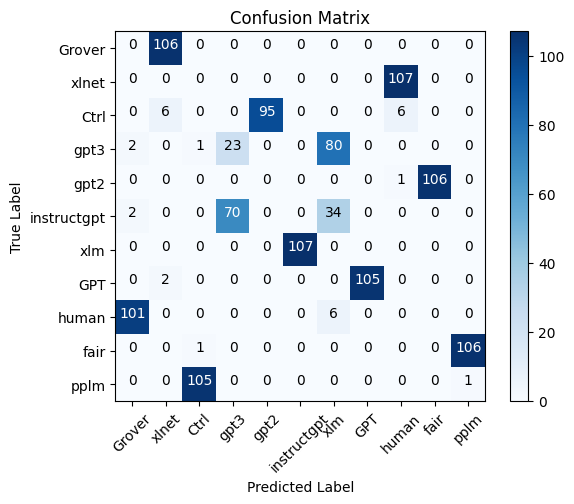

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# example ground truth and predictions
y_true = temp_df['1'].to_list()
y_pred = df_pred[1].to_list()

# create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# print the confusion matrix
print(cm)

# plot the confusion matrix
classes = ['Grover', 'xlnet', 'Ctrl', 'gpt3', 'gpt2', 'instructgpt', 'xlm', 'GPT', 'human', 'fair', 'pplm']
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Task 2

### Prepare the Data

In [ ]:
TASK = 2

label2id = {
    'human': 0,
    'machine': 1 
}

In [ ]:
batcher = SynBatcher(tnkzr_path=MPATH,has_targets=False)
eval_dm = SynDataModule(data_path=DPATH, task='hvm', label2id=label2id, batcher=batcher)
# train_dm.setup('fit')

### Prepare the model

In [ ]:
SAVE_PATH = "../models/task2/roberta-base"

# model = SequenceClassification(MPATH, num_labels=len(label2id))
# print("Loaded fresh model")
model = SequenceClassification.load_from_checkpoint("../models/task2/roberta-base/task-2-epoch=1-val_loss=0.03.ckpt")

checkpoint_callback = ModelCheckpoint(
    SAVE_PATH,
    filename=f'task-{TASK}-{{epoch}}-{{val_loss:.2f}}',
    monitor='val_loss',
    save_weights_only=True,
)
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4, patience=8,
    verbose=False,
    mode="min"
)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.b

### Train the model

In [ ]:
#This looks the same as the first trainer

trainer = Trainer(
    max_epochs=-1,
    deterministic=True,
    accumulate_grad_batches=4,
    callbacks=[checkpoint_callback, early_stop_callback, RichModelSummary()],
    accelerator='gpu',
    log_every_n_steps=16
)

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.test(model, eval_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
